In [26]:
import svgpathtools as spt
from svgpathtools import parse_path, Line, Path, wsvg, Arc, disvg
import numpy as np
import math

import tempfile, os
from IPython.display import SVG, display

import warnings

def disp_svg(paths):
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_svg = os.path.join(tmp_dir, 'display.svg')
        spt.wsvg(paths, filename = tmp_svg)
        display(SVG(tmp_svg))
def save_svg(paths, name, params):
    spt.wsvg(paths,filename = f'pathout_{name}_{params}.svg', baseunit='mm',mindim=None)
# spt.disvg??

In [6]:

def offset_curve(path, offset_distance, steps=1000):
    """Takes in a Path object, `path`, and a distance,
    `offset_distance`, and outputs an piecewise-linear approximation 
    of the 'parallel' offset curve."""
    nls = []
    for seg in path:
        ct = 1
        for k in range(steps):
            t = k / steps
            offset_vector = offset_distance * seg.normal(t)
            nl = Line(seg.point(t), seg.point(t) + offset_vector)
            nls.append(nl)
    connect_the_dots = [Line(nls[k].end, nls[k+1].end) for k in range(len(nls)-1)]
    if path.isclosed():
        connect_the_dots.append(Line(nls[-1].end, nls[0].end))
    offset_path = Path(*connect_the_dots)
    return offset_path

# Examples:
path1 = parse_path("m 288,600 c -52,-28 -42,-61 0,-97 ")
path2 = parse_path("M 151,395 C 407,485 726.17662,160 634,339").translated(300)
path3 = parse_path("m 117,695 c 237,-7 -103,-146 457,0").translated(500+400j)
paths = [path1, path2, path3]

offset_distances = [10*k for k in range(1,51)]
offset_paths = []
for path in paths:
    for distances in offset_distances:
        offset_paths.append(offset_curve(path, distances))

# Let's take a look
# wsvg(paths + offset_paths, 'g'*len(paths) + 'r'*len(offset_paths), filename='offset_curves.svg')
disvg(paths+ offset_paths) 

In [7]:

def get_cut_circle(radius, n_bridge, h_bridge, angle_bridge, sweep_angle_factor = 0):
    '''
        radius   :: Center radius of circle
        n_bridge :: Number of bridges
        h_bridge :: Height of the bridge/cut
        angle_bridge :: Angle the bridge subtends (results in w_bridge)
    '''
    if (n_bridge*angle_bridge > 360):
        warnings.warn("The amount of angle subtended by the bridges is larger than 360 degrees")
        
    h_cut = h_bridge
    radius_inner = (radius - h_cut/2)   +   (radius - h_cut/2)*1j ## ellipse, majorminor
    radius_outer = (radius + h_cut/2)   +   (radius + h_cut/2)*1j

    inter_angle = angle_bridge
    sweep_angle = 360/n_bridge - inter_angle

    w_bridge = radius*math.radians(inter_angle) ## note radius is center radius
    print(f'The resultant bridge is {w_bridge:.3g} thick at the current radius')
    # w_bridge = 
    # inter_angle = w_bridge*360/radius

    paths=[]
    for i in range(n_bridge):

        angle_offset = (sweep_angle+inter_angle)*sweep_angle_factor + i * inter_angle + i * sweep_angle

        radius = radius_inner
        x0_inner = radius.real
        x1_inner = radius.real*np.cos(math.radians(sweep_angle)) + radius.imag*np.sin(math.radians(sweep_angle))*1j

        radius = radius_outer
        x0_outer = radius.real
        x1_outer = radius.real*np.cos(math.radians(sweep_angle)) + radius.imag*np.sin(math.radians(sweep_angle))*1j

        arc_inner = Arc(x0_inner,radius_inner,0,large_arc=False,sweep=True,end=x1_inner)
        line_1    = Line(x1_inner,x1_outer)
        arc_outer = Arc(x1_outer,radius_outer,0,large_arc=False,sweep=False,end=x0_outer)
        line_0    = Line(x0_outer,x0_inner)


        path = Path(arc_inner, line_1, arc_outer, line_0)

        paths.append(path.rotated(angle_offset,origin=0))
    return paths


The resultant bridge is 1.12 thick at the current radius
The resultant bridge is 1.52 thick at the current radius
The resultant bridge is 1.92 thick at the current radius
The resultant bridge is 2.32 thick at the current radius
The resultant bridge is 2.72 thick at the current radius
The resultant bridge is 3.13 thick at the current radius
The resultant bridge is 3.53 thick at the current radius
The resultant bridge is 3.93 thick at the current radius


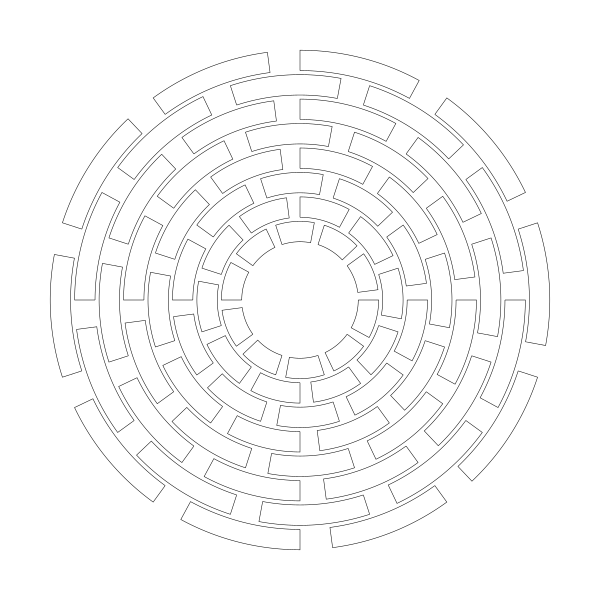

The resultant bridge is 1.12 thick at the current radius
The resultant bridge is 1.52 thick at the current radius
The resultant bridge is 1.92 thick at the current radius
The resultant bridge is 2.32 thick at the current radius
The resultant bridge is 2.72 thick at the current radius
The resultant bridge is 3.13 thick at the current radius
The resultant bridge is 3.53 thick at the current radius
The resultant bridge is 3.93 thick at the current radius


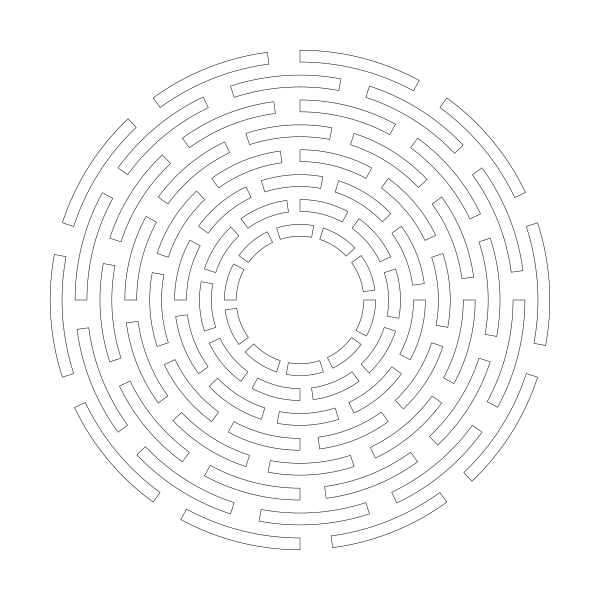

The resultant bridge is 1.12 thick at the current radius
The resultant bridge is 1.52 thick at the current radius
The resultant bridge is 1.92 thick at the current radius
The resultant bridge is 2.32 thick at the current radius
The resultant bridge is 2.72 thick at the current radius
The resultant bridge is 3.13 thick at the current radius
The resultant bridge is 3.53 thick at the current radius
The resultant bridge is 3.93 thick at the current radius


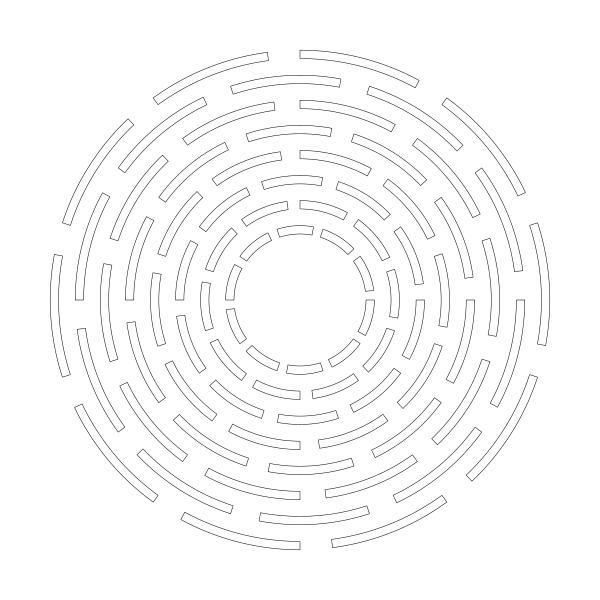

In [101]:
inner = 8.57
outer = 30
n_circles = 8
radii = np.linspace(inner,outer,n_circles)
circle_distance = (outer-inner)/(n_circles-1) ##note to self, changed this from n_circles

from itertools import cycle

lst = [0,0.5]

angle_bridge = 7.5
bridge_factors =  np.linspace(1.2,3,3)
n_bridge = 10
for bf  in bridge_factors:
    pool = cycle(lst)
    paths=[]
    h_bridge = circle_distance/bf
    for r in radii:
        paths+=(get_cut_circle(radius=r, n_bridge=n_bridge, angle_bridge=angle_bridge, h_bridge=h_bridge, sweep_angle_factor=next(pool)))
    disp_svg(paths)
    # save_svg(paths, name='compliance', params=f'r{outer}n{n_bridge}a{angle_bridge}hbridge{h_bridge:.3f}')

The resultant bridge is 0.916 thick at the current radius
The resultant bridge is 0.982 thick at the current radius
The resultant bridge is 1.05 thick at the current radius


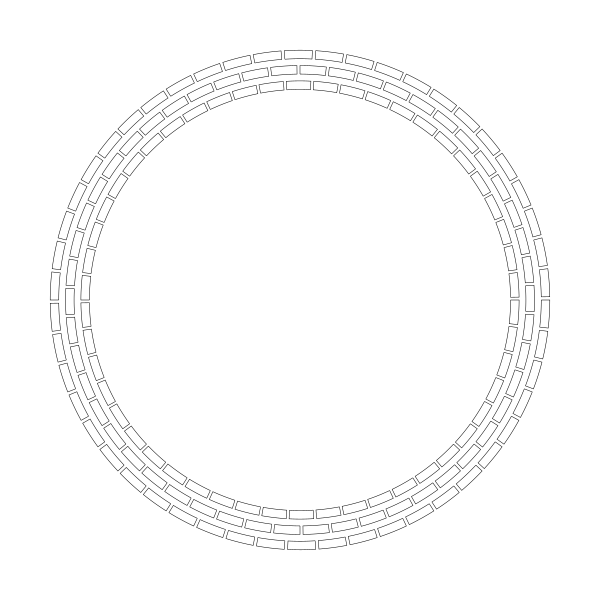

In [140]:
## Stargate
inner = 70
outer = 80
n_circles = 3
radii = np.linspace(inner,outer,n_circles)
circle_distance = (outer-inner)/(n_circles-1) ##note to self, changed this from n_circles

from itertools import cycle

lst = [0,0.5]
pool = cycle(lst)

angle_bridge = 0.75
bf = 1.8
n_bridge = 50

paths=[]
h_bridge = circle_distance/bf
for r in radii:
    paths+=(get_cut_circle(radius=r, n_bridge=n_bridge, angle_bridge=angle_bridge, h_bridge=h_bridge, sweep_angle_factor=next(pool)))
disp_svg(paths)

save_svg(paths, name='snake', params=f'r{outer}n{n_bridge}a{angle_bridge}hbridge{h_bridge:.3f}')


In [43]:
circle_distance

3.5714285714285716

190
The resultant bridge is 6.63 thick at the current radius


/var/folders/0p/j_4pkrn953x_vymtqt6kvnwm0000gn/T/ipykernel_79548/1253197466.py:9: UserWarning: The amount of angle subtended by the bridges is larger than 360 degrees
  warnings.warn("The amount of angle subtended by the bridges is larger than 360 degrees")


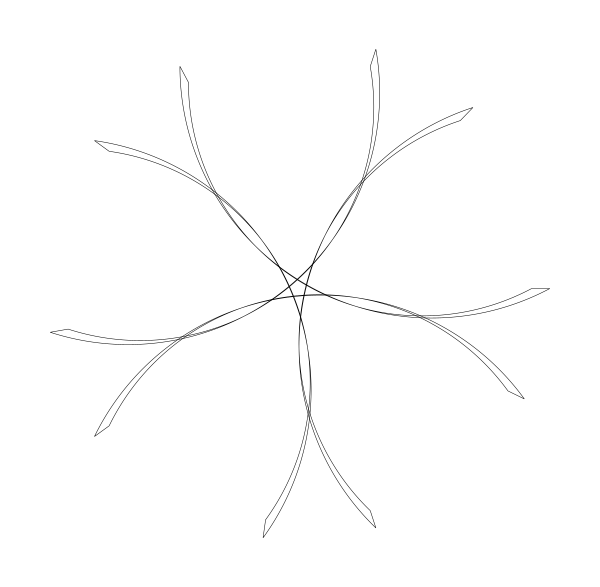

216
The resultant bridge is 7.54 thick at the current radius


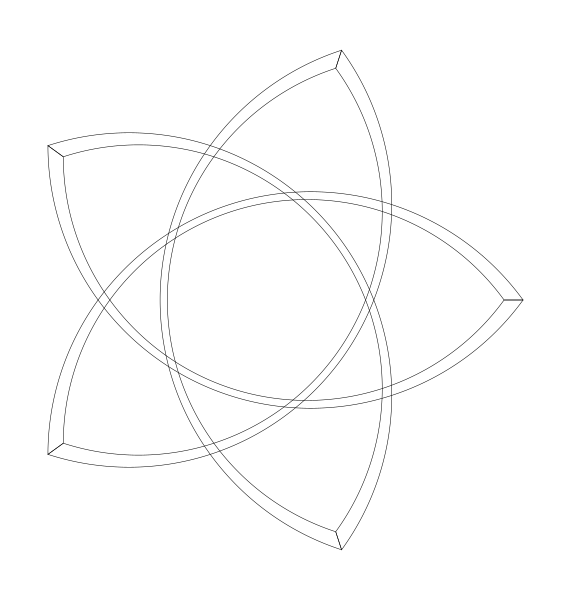

310
The resultant bridge is 10.8 thick at the current radius


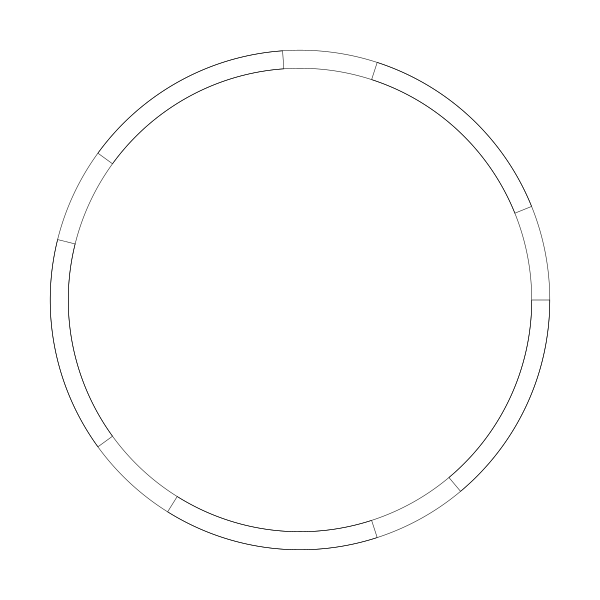

In [85]:
## Obligatory art
#
for a in [190,216,310]:#np.linspace(180,220,100):
    print(a)
    paths=get_cut_circle(radius=2, n_bridge=5, angle_bridge=a, h_bridge=0.15)
    disp_svg(paths)

The resultant bridge is 0.374 thick at the current radius
The resultant bridge is 0.441 thick at the current radius
The resultant bridge is 0.508 thick at the current radius
The resultant bridge is 0.574 thick at the current radius
The resultant bridge is 0.641 thick at the current radius
The resultant bridge is 0.708 thick at the current radius
The resultant bridge is 0.775 thick at the current radius
The resultant bridge is 0.841 thick at the current radius
The resultant bridge is 0.908 thick at the current radius
The resultant bridge is 0.975 thick at the current radius
The resultant bridge is 1.04 thick at the current radius
The resultant bridge is 1.11 thick at the current radius
The resultant bridge is 1.18 thick at the current radius
The resultant bridge is 1.24 thick at the current radius
The resultant bridge is 1.31 thick at the current radius


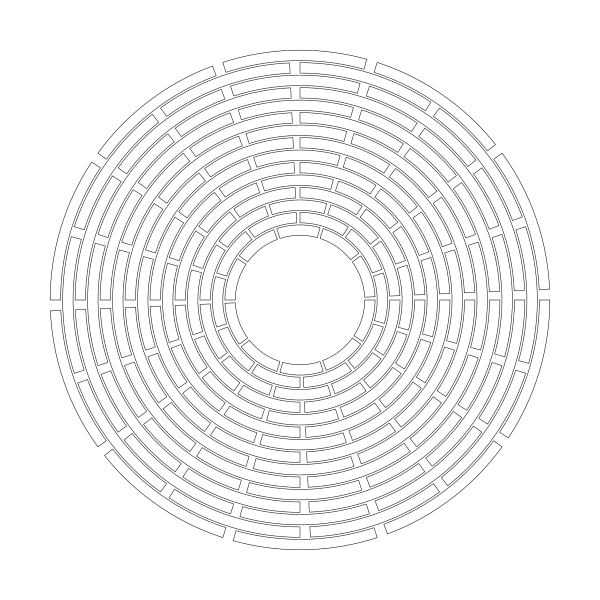

The resultant bridge is 0.374 thick at the current radius
The resultant bridge is 0.441 thick at the current radius
The resultant bridge is 0.508 thick at the current radius
The resultant bridge is 0.574 thick at the current radius
The resultant bridge is 0.641 thick at the current radius
The resultant bridge is 0.708 thick at the current radius
The resultant bridge is 0.775 thick at the current radius
The resultant bridge is 0.841 thick at the current radius
The resultant bridge is 0.908 thick at the current radius
The resultant bridge is 0.975 thick at the current radius
The resultant bridge is 1.04 thick at the current radius
The resultant bridge is 1.11 thick at the current radius
The resultant bridge is 1.18 thick at the current radius
The resultant bridge is 1.24 thick at the current radius
The resultant bridge is 1.31 thick at the current radius


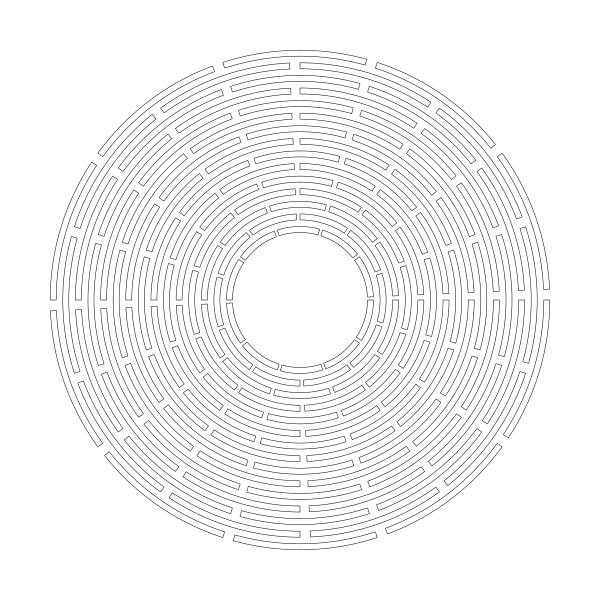

The resultant bridge is 0.374 thick at the current radius
The resultant bridge is 0.441 thick at the current radius
The resultant bridge is 0.508 thick at the current radius
The resultant bridge is 0.574 thick at the current radius
The resultant bridge is 0.641 thick at the current radius
The resultant bridge is 0.708 thick at the current radius
The resultant bridge is 0.775 thick at the current radius
The resultant bridge is 0.841 thick at the current radius
The resultant bridge is 0.908 thick at the current radius
The resultant bridge is 0.975 thick at the current radius
The resultant bridge is 1.04 thick at the current radius
The resultant bridge is 1.11 thick at the current radius
The resultant bridge is 1.18 thick at the current radius
The resultant bridge is 1.24 thick at the current radius
The resultant bridge is 1.31 thick at the current radius


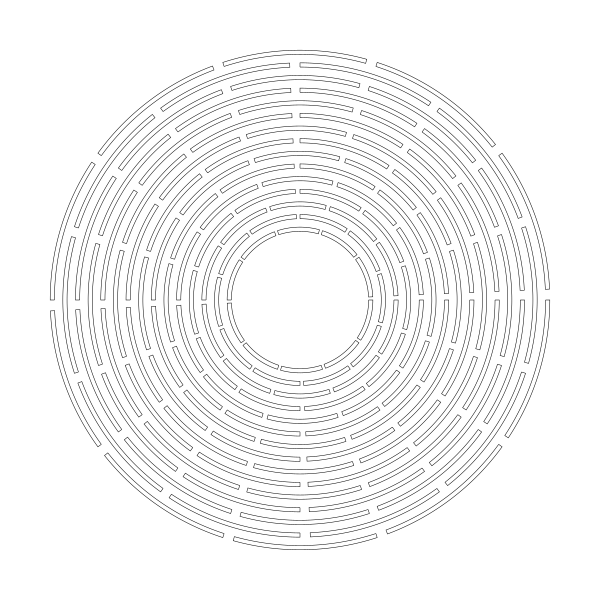

In [99]:
inner = 8.57
outer = 30
n_circles = 15
radii = np.linspace(inner,outer,n_circles)
circle_distance = (outer-inner)/(n_circles-1) ##note to self, changed this from n_circles

from itertools import cycle

lst = [0,0.5]

angle_bridge = 2.5
bridge_factors =  np.linspace(1.2,3,3)
n_bridge = 10
for bf  in bridge_factors:
    pool = cycle(lst)
    paths=[]
    h_bridge = circle_distance/bf
    for r in radii:
        paths+=(get_cut_circle(radius=r, n_bridge=n_bridge, angle_bridge=angle_bridge, h_bridge=h_bridge, sweep_angle_factor=next(pool)))
    disp_svg(paths)
    # save_svg(paths, name='compliance', params=f'r{outer}n{n_bridge}a{angle_bridge}hbridge{h_bridge:.3f}')